In [19]:
# from __future__ import print_function, division

import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
# import time
import os

# plt.ion()

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Transfer Learning Tutorial/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [12]:
print(dataset_sizes)

{'train': 244, 'val': 153}


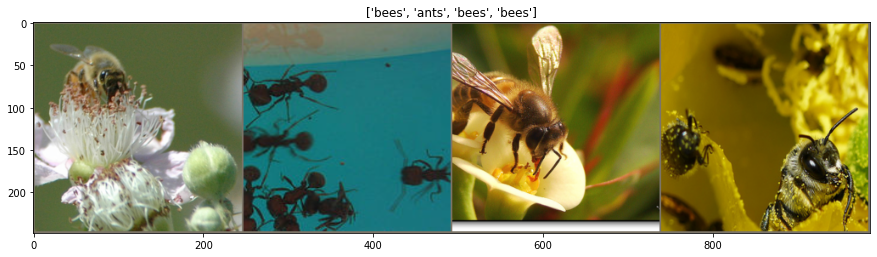

In [27]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [24]:
for i in dataloaders['train']:
    print(i[0][0])
    break 

tensor([[[ 0.8789,  0.9303, -0.8335,  ...,  0.6049,  0.4508,  0.6049],
         [ 1.2043,  1.3242,  0.7077,  ...,  0.4508,  0.1939,  1.4783],
         [ 1.3584,  1.2557,  1.2899,  ...,  0.1768,  0.6734,  1.8722],
         ...,
         [-2.1179, -2.1179, -2.1179,  ...,  0.2111,  0.1597,  0.2111],
         [-2.1179, -2.1179, -2.1179,  ...,  0.2111, -0.0629, -0.2856],
         [-2.1179, -2.1179, -2.1179,  ..., -0.1828,  0.0056, -0.1314]],

        [[ 0.4328,  0.5553, -1.2304,  ..., -0.4076, -0.8803, -0.3901],
         [ 0.5728,  0.6954,  0.0826,  ..., -0.7927, -0.9853,  1.1681],
         [ 0.6779,  0.5378,  0.5553,  ..., -1.1779, -0.1975,  1.8859],
         ...,
         [-2.0357, -2.0357, -2.0357,  ...,  0.0476, -0.0049,  0.0651],
         [-2.0357, -2.0357, -2.0357,  ...,  0.1877, -0.1099, -0.2850],
         [-2.0357, -2.0357, -2.0357,  ..., -0.1975, -0.0049, -0.0749]],

        [[ 0.3393,  0.4614, -1.1421,  ..., -0.0267, -1.0898, -0.9330],
         [ 0.5834,  0.5834, -0.0441,  ..., -0

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0.0


            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels
                
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [29]:
# def visualize_model(model, num_images=6):
#     images_so_far = 0
#     fig = plt.figure()

#     for i, data in enumerate(dataloaders['val']):
#         inputs, labels = data
#         if use_gpu:
#             inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
#         else:
#             inputs, labels = Variable(inputs), Variable(labels)

#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)

#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(num_images // 2, 2, images_so_far)
#             ax.axis('off')
#             ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#             imshow(inputs.cpu().data[j])

#             if images_so_far == num_images:
#                 return

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [30]:
def evaluate(model):
    model.train(False)

    running_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs, labels = inputs, labels

        output = model.inputs
        _, predicted = torch.max(output, 1)
        print(torch.sum(predicted == labels))
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']